# Multi-Domain Deepfake Detection - Baseline Model

## Overview
This notebook implements a **baseline multi-domain deepfake detection system** that fuses features from three distinct domains:

1. **Spatial Domain**: Uses pretrained **XceptionNet** to capture fine-grained pixel-level artifacts
2. **Frequency Domain**: Applies **Fast Fourier Transform (FFT)** to analyze frequency spectrum patterns
3. **Semantic Domain**: Employs **DINOv2 Vision Transformer** to extract high-level semantic features

### Pipeline Stages
1. **Data Preparation**: Directory setup and metadata generation
2. **Preprocessing**: Face detection and extraction using MTCNN
3. **Feature Extraction**: Extract features from all three domains
4. **Multi-Domain Fusion**: Concatenation-based fusion
5. **Training**: Train MLP classifier on fused features
6. **Evaluation**: Performance metrics and visualization

### Dataset
- **FaceForensics++** with flat directory structure
- Categories: `original/`, `Deepfakes/`, `Face2Face/`, `FaceSwap/`, `NeuralTextures/`, `FaceShifter/`, `DeepFakeDetection/`
- Currently using 50 videos per category for demo (scalable to full dataset)

## Section 1: Environment Setup and Imports

Import all necessary libraries and check CUDA availability for GPU acceleration.

In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import random
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Models
import timm
from facenet_pytorch import MTCNN

# Analysis and visualization
from scipy.stats import skew, kurtosis
from scipy import fft
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("Running on CPU - training will be slower")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 12.4


## Section 2: Directory Setup and Configuration

Define project paths and create necessary directories for storing preprocessed data, extracted features, and model checkpoints.

In [2]:
# Configuration
BASE_DIR = Path('.')
FFPP_DIR = BASE_DIR / 'FaceForensics++'
PREPROCESSED_DIR = BASE_DIR / 'preprocessed_faces'
FEATURES_DIR = BASE_DIR / 'extracted_features'
CHECKPOINTS_DIR = BASE_DIR / 'checkpoints_baseline'
METADATA_PATH = BASE_DIR / 'ffpp_metadata.csv'

# Hyperparameters
DEMO_LIMIT = 50  # Number of videos per category (set to None for full dataset)
FRAMES_PER_VIDEO = 20  # Number of frames to extract from each video
FACE_SIZE = 299  # Input size for Xception (299x299)
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 10
HIDDEN_DIM1 = 512
HIDDEN_DIM2 = 256
DROPOUT = 0.5

# Create directory structure
def create_directory_structure():
    """Create all necessary directories for the project."""
    dirs = [
        PREPROCESSED_DIR,
        FEATURES_DIR / 'spatial',
        FEATURES_DIR / 'frequency',
        FEATURES_DIR / 'semantic',
        CHECKPOINTS_DIR
    ]
    for dir_path in dirs:
        dir_path.mkdir(parents=True, exist_ok=True)
    print("✓ Directory structure created successfully")

create_directory_structure()

# Display configuration
print("\n" + "="*60)
print("PROJECT CONFIGURATION")
print("="*60)
print(f"Base Directory: {BASE_DIR.absolute()}")
print(f"Dataset Directory: {FFPP_DIR}")
print(f"Demo Mode: {DEMO_LIMIT} videos per category" if DEMO_LIMIT else "Full dataset mode")
print(f"Frames per video: {FRAMES_PER_VIDEO}")
print(f"Face size: {FACE_SIZE}x{FACE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print("="*60)

✓ Directory structure created successfully

PROJECT CONFIGURATION
Base Directory: D:\MMF-Deepfake-Detection
Dataset Directory: FaceForensics++
Demo Mode: 50 videos per category
Frames per video: 20
Face size: 299x299
Batch size: 128
Learning rate: 0.0001
Epochs: 10


## Section 3: Metadata Generation

Scan the FaceForensics++ dataset directories and create a metadata CSV file containing:
- Video IDs
- Labels (real/fake)
- Full file paths
- Manipulation methods

This step is **resumable** - it will skip if the metadata file already exists.

In [5]:
def generate_metadata(ffpp_dir, output_path, limit_per_category=None):
    """
    Generate metadata CSV file for FaceForensics++ dataset.
    
    Args:
        ffpp_dir: Root directory of FaceForensics++ dataset
        output_path: Path to save metadata CSV
        limit_per_category: Limit number of videos per category (None for all)
    """
    print("\n" + "="*60)
    print("GENERATING METADATA")
    print("="*60)
    print(f"Scanning directory: {ffpp_dir}")
    
    # List all subdirectories to see actual structure
    print("\nAvailable directories:")
    for item in ffpp_dir.iterdir():
        if item.is_dir():
            print(f"  - {item.name}")
    
    if limit_per_category:
        print(f"\nDemo Mode: Limiting to {limit_per_category} videos per category")
    
    data = []
    
    # Process original (real) videos - try multiple common naming conventions
    original_dirs = ['original', 'original_sequences', 'youtube', 'real']
    original_dir = None
    
    for dir_name in original_dirs:
        test_dir = ffpp_dir / dir_name
        if test_dir.exists():
            original_dir = test_dir
            print(f"\n✓ Found original videos directory: {dir_name}")
            break
    
    if original_dir and original_dir.exists():
        # Look for videos in the directory and subdirectories
        original_videos = list(original_dir.rglob('*.mp4'))
        if not original_videos:
            original_videos = list(original_dir.rglob('*.avi'))
        
        if limit_per_category:
            original_videos = original_videos[:limit_per_category]
        
        for video_path in original_videos:
            video_id = video_path.stem
            data.append({
                'video_id': video_id,
                'label': 'real',
                'path': str(video_path),
                'manipulation': 'Original'
            })
        print(f"  Found {len(original_videos)} original videos")
    else:
        print(f"\n⚠ Warning: No original videos directory found. Tried: {original_dirs}")
    
    # Process manipulated (fake) videos - using actual folder names from dataset
    manipulation_methods = [
        'Deepfakes', 'deepfakes',
        'Face2Face', 'face2face', 
        'FaceSwap', 'faceswap',
        'NeuralTextures', 'neuraltextures',
        'FaceShifter', 'faceshifter',
        'DeepFakeDetection', 'deepfakedetection'
    ]
    
    # Remove duplicates while preserving order
    seen = set()
    unique_methods = []
    for method in manipulation_methods:
        lower_method = method.lower()
        if lower_method not in seen:
            seen.add(lower_method)
            unique_methods.append(method)
    
    for method in unique_methods:
        method_dir = ffpp_dir / method
        if method_dir.exists():
            # Search for videos recursively
            manipulated_videos = list(method_dir.rglob('*.mp4'))
            if not manipulated_videos:
                manipulated_videos = list(method_dir.rglob('*.avi'))
            
            if limit_per_category:
                manipulated_videos = manipulated_videos[:limit_per_category]
            
            for video_path in manipulated_videos:
                video_id = video_path.stem
                data.append({
                    'video_id': f"{method}_{video_id}",
                    'label': 'fake',
                    'path': str(video_path),
                    'manipulation': method
                })
            print(f"✓ Found {len(manipulated_videos)} {method} videos")
        else:
            # Try lowercase version
            method_dir_lower = ffpp_dir / method.lower()
            if method_dir_lower.exists():
                manipulated_videos = list(method_dir_lower.rglob('*.mp4'))
                if not manipulated_videos:
                    manipulated_videos = list(method_dir_lower.rglob('*.avi'))
                
                if limit_per_category:
                    manipulated_videos = manipulated_videos[:limit_per_category]
                
                for video_path in manipulated_videos:
                    video_id = video_path.stem
                    data.append({
                        'video_id': f"{method}_{video_id}",
                        'label': 'fake',
                        'path': str(video_path),
                        'manipulation': method
                    })
                print(f"✓ Found {len(manipulated_videos)} {method.lower()} videos")
    
    # Save to CSV
    df = pd.DataFrame(data)
    df.to_csv(output_path, index=False)
    
    print("\n" + "="*60)
    print(f"Metadata saved to: {output_path}")
    print(f"Total videos: {len(df)}")
    print(f"Real videos: {len(df[df['label'] == 'real'])}")
    print(f"Fake videos: {len(df[df['label'] == 'fake'])}")
    print("="*60)
    
    return df


def load_or_generate_metadata(ffpp_dir, metadata_path, demo_limit=None):
    """
    Load existing metadata or generate new one, handling empty/corrupt files.
    
    Args:
        ffpp_dir: Root directory of FaceForensics++ dataset
        metadata_path: Path to metadata CSV
        demo_limit: Limit number of videos per category (None for all)
    
    Returns:
        pd.DataFrame: Metadata dataframe
    """
    # Check if file exists and is valid
    if metadata_path.exists():
        try:
            # Try to read the CSV
            metadata_df = pd.read_csv(metadata_path)
            
            # Check if it has data
            if len(metadata_df) > 0:
                print(f"\n✓ Metadata file loaded successfully from {metadata_path}")
                print(f"Loaded {len(metadata_df)} video entries")
                return metadata_df
            else:
                print(f"\n⚠ Metadata file exists but is empty. Regenerating...")
        except (pd.errors.EmptyDataError, pd.errors.ParserError) as e:
            print(f"\n⚠ Metadata file is corrupted or empty: {e}")
            print("Regenerating metadata...")
    else:
        print(f"\n✓ No metadata file found. Generating new metadata...")
    
    # Generate new metadata
    metadata_df = generate_metadata(ffpp_dir, metadata_path, demo_limit)
    return metadata_df


# Usage
metadata_df = load_or_generate_metadata(FFPP_DIR, METADATA_PATH, DEMO_LIMIT)

# Display sample metadata
print("\nSample metadata:")
print(metadata_df.head(10))

print("\nMetadata statistics:")
print(f"Total videos: {len(metadata_df)}")
print(f"Real videos: {len(metadata_df[metadata_df['label'] == 'real'])}")
print(f"Fake videos: {len(metadata_df[metadata_df['label'] == 'fake'])}")
print("\nVideos per manipulation type:")
print(metadata_df['manipulation'].value_counts())


⚠ Metadata file is corrupted or empty: No columns to parse from file
Regenerating metadata...

GENERATING METADATA
Scanning directory: FaceForensics++

Available directories:
  - csv
  - DeepFakeDetection
  - Deepfakes
  - Face2Face
  - FaceShifter
  - FaceSwap
  - NeuralTextures
  - original

Demo Mode: Limiting to 50 videos per category

✓ Found original videos directory: original
  Found 50 original videos
✓ Found 50 Deepfakes videos
✓ Found 50 Face2Face videos
✓ Found 50 FaceSwap videos
✓ Found 50 NeuralTextures videos
✓ Found 50 FaceShifter videos
✓ Found 50 DeepFakeDetection videos

Metadata saved to: ffpp_metadata.csv
Total videos: 350
Real videos: 50
Fake videos: 300

Sample metadata:
  video_id label                              path manipulation
0      000  real  FaceForensics++\original\000.mp4     Original
1      001  real  FaceForensics++\original\001.mp4     Original
2      002  real  FaceForensics++\original\002.mp4     Original
3      003  real  FaceForensics++\origina

## Section 4: Face Detection and Extraction with MTCNN

Extract faces from videos using **MTCNN (Multi-task Cascaded Convolutional Networks)**:
- Detects faces in sampled video frames
- Crops and aligns detected faces
- Saves preprocessed face images (299x299)

This process is **resumable** - already processed videos will be skipped.

In [6]:
def extract_faces_from_videos(metadata_df, output_dir, frames_per_video=20, image_size=299):
    """
    Extract faces from videos using MTCNN.
    
    Args:
        metadata_df: DataFrame with video metadata
        output_dir: Directory to save extracted faces
        frames_per_video: Number of frames to sample from each video
        image_size: Output size of cropped face images
    """
    print("\n" + "="*60)
    print("FACE EXTRACTION WITH MTCNN")
    print("="*60)
    print(f"Device: {device}")
    
    # Initialize MTCNN
    mtcnn = MTCNN(
        image_size=image_size,
        margin=40,
        min_face_size=20,
        thresholds=[0.6, 0.7, 0.7],
        factor=0.709,
        post_process=True,
        keep_all=False,  # Only keep the largest face
        device=device
    )
    
    print(f"\nProcessing {len(metadata_df)} videos...")
    
    processed_count = 0
    skipped_count = 0
    error_count = 0
    
    for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Extracting faces"):
        video_path = row['path']
        video_id = row['video_id']
        label = row['label']
        
        # Create output directory for this video
        video_output_dir = output_dir / label / str(video_id)
        
        # Skip if already processed
        if video_output_dir.exists() and len(list(video_output_dir.glob('*.png'))) >= frames_per_video:
            skipped_count += 1
            continue
        
        video_output_dir.mkdir(parents=True, exist_ok=True)
        
        try:
            # Open video
            cap = cv2.VideoCapture(str(video_path))
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            if total_frames == 0:
                print(f"\n⚠ Warning: No frames in {video_path}")
                error_count += 1
                continue
            
            # Sample frames uniformly
            frame_indices = torch.linspace(0, total_frames - 1, frames_per_video).long()
            
            saved_count = 0
            for frame_idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx.item())
                ret, frame = cap.read()
                
                if not ret:
                    continue
                
                # Convert BGR to RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Detect and extract face
                face = mtcnn(frame_rgb)
                
                if face is not None:
                    save_path = video_output_dir / f'frame_{saved_count}.png'
                    # Convert tensor to numpy and save
                    face_np = (face.permute(1, 2, 0).cpu().numpy() * 255.0).clip(0, 255).astype('uint8')
                    face_bgr = cv2.cvtColor(face_np, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(str(save_path), face_bgr)
                    saved_count += 1
                
                if saved_count >= frames_per_video:
                    break
            
            cap.release()
            processed_count += 1
            
        except Exception as e:
            print(f"\n✗ Error processing {video_path}: {e}")
            error_count += 1
    
    print("\n" + "="*60)
    print(f"Face extraction complete!")
    print(f"Processed: {processed_count} videos")
    print(f"Skipped (already done): {skipped_count} videos")
    print(f"Errors: {error_count} videos")
    print("="*60)

# Run face extraction
extract_faces_from_videos(metadata_df, PREPROCESSED_DIR, FRAMES_PER_VIDEO, FACE_SIZE)


FACE EXTRACTION WITH MTCNN
Device: cuda

Processing 350 videos...


Extracting faces: 100%|██████████████████████████████████████████████████████████████| 350/350 [23:43<00:00,  4.07s/it]


Face extraction complete!
Processed: 350 videos
Skipped (already done): 0 videos
Errors: 0 videos


## Section 5: Feature Extraction - Spatial Domain (Xception)

Extract **spatial features** using a pretrained **XceptionNet** model:
- Removes the final classification layer
- Extracts 2048-dimensional feature vectors
- Captures fine-grained texture and pixel-level artifacts

**XceptionNet** is particularly effective for deepfake detection due to its depthwise separable convolutions that capture subtle manipulation artifacts.

In [8]:
class SpatialExtractor(nn.Module):
    """XceptionNet-based spatial feature extractor."""
    
    def __init__(self):
        super().__init__()
        # Load pretrained Xception without classification head
        self.model = timm.create_model('xception', pretrained=True, num_classes=0)
        self.model.eval()
        
        # Xception preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
    
    @torch.no_grad()
    def forward(self, img_path):
        """Extract spatial features from an image."""
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(device)
        features = self.model(img_tensor)
        return features.squeeze().cpu().numpy()

def extract_spatial_features(preprocessed_dir, output_dir):
    """Extract spatial features from all preprocessed faces."""
    print("\n" + "="*60)
    print("EXTRACTING SPATIAL FEATURES (XCEPTION)")
    print("="*60)
    
    extractor = SpatialExtractor().to(device)
    
    # Collect all image paths
    image_paths = []
    for label in ['real', 'fake']:
        label_dir = preprocessed_dir / label
        if label_dir.exists():
            for video_dir in label_dir.iterdir():
                if video_dir.is_dir():
                    for img_path in video_dir.glob('*.png'):
                        image_paths.append(img_path)
    
    print(f"Processing {len(image_paths)} images...")
    
    processed = 0
    skipped = 0
    
    for img_path in tqdm(image_paths, desc="Extracting spatial features"):
        # Create output path preserving directory structure
        relative_path = img_path.relative_to(preprocessed_dir)
        feature_path = output_dir / 'spatial' / relative_path.with_suffix('.npy')
        
        # Skip if already processed
        if feature_path.exists():
            skipped += 1
            continue
        
        feature_path.parent.mkdir(parents=True, exist_ok=True)
        
        try:
            features = extractor(img_path)
            np.save(feature_path, features)
            processed += 1
        except Exception as e:
            print(f"\n✗ Error processing {img_path}: {e}")
    
    print(f"\n✓ Spatial feature extraction complete!")
    print(f"  Processed: {processed}, Skipped: {skipped}")
    print(f"  Feature dimension: 2048")
    print("="*60)

# Extract spatial features
extract_spatial_features(PREPROCESSED_DIR, FEATURES_DIR)


EXTRACTING SPATIAL FEATURES (XCEPTION)
Processing 6997 images...


Extracting spatial features: 100%|██████████████████████████████████████████████| 6997/6997 [00:00<00:00, 10206.78it/s]


✓ Spatial feature extraction complete!
  Processed: 0, Skipped: 6997
  Feature dimension: 2048


## Section 6: Feature Extraction - Frequency Domain (FFT)

Extract **frequency features** using **Fast Fourier Transform**:
- Converts images to frequency domain
- Analyzes magnitude spectrum
- Extracts statistical features: mean, variance, skewness, kurtosis

Deepfake generation often introduces unnatural periodic patterns in the frequency domain that are imperceptible in spatial domain.

In [9]:
class FrequencyExtractor:
    """FFT-based frequency feature extractor."""
    
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])
    
    def extract(self, img_path):
        """Extract frequency features from an image."""
        img = Image.open(img_path)
        img_tensor = self.transform(img)
        
        # Apply 2D FFT
        f_transform = torch.fft.fft2(img_tensor)
        f_shift = torch.fft.fftshift(f_transform)
        magnitude_spectrum = torch.log(torch.abs(f_shift) + 1).numpy().flatten()
        
        # Extract statistical features
        mean = np.mean(magnitude_spectrum)
        var = np.var(magnitude_spectrum)
        skewness = skew(magnitude_spectrum)
        kurt = kurtosis(magnitude_spectrum)
        
        return np.array([mean, var, skewness, kurt], dtype=np.float32)

def extract_frequency_features(preprocessed_dir, output_dir):
    """Extract frequency features from all preprocessed faces."""
    print("\n" + "="*60)
    print("EXTRACTING FREQUENCY FEATURES (FFT)")
    print("="*60)
    
    extractor = FrequencyExtractor()
    
    # Collect all image paths
    image_paths = []
    for label in ['real', 'fake']:
        label_dir = preprocessed_dir / label
        if label_dir.exists():
            for video_dir in label_dir.iterdir():
                if video_dir.is_dir():
                    for img_path in video_dir.glob('*.png'):
                        image_paths.append(img_path)
    
    print(f"Processing {len(image_paths)} images...")
    
    processed = 0
    skipped = 0
    
    for img_path in tqdm(image_paths, desc="Extracting frequency features"):
        # Create output path
        relative_path = img_path.relative_to(preprocessed_dir)
        feature_path = output_dir / 'frequency' / relative_path.with_suffix('.npy')
        
        # Skip if already processed
        if feature_path.exists():
            skipped += 1
            continue
        
        feature_path.parent.mkdir(parents=True, exist_ok=True)
        
        try:
            features = extractor.extract(img_path)
            np.save(feature_path, features)
            processed += 1
        except Exception as e:
            print(f"\n✗ Error processing {img_path}: {e}")
    
    print(f"\n✓ Frequency feature extraction complete!")
    print(f"  Processed: {processed}, Skipped: {skipped}")
    print(f"  Feature dimension: 4 (mean, var, skewness, kurtosis)")
    print("="*60)

# Extract frequency features
extract_frequency_features(PREPROCESSED_DIR, FEATURES_DIR)


EXTRACTING FREQUENCY FEATURES (FFT)
Processing 6997 images...


Extracting frequency features: 100%|██████████████████████████████████████████████| 6997/6997 [00:33<00:00, 211.19it/s]


✓ Frequency feature extraction complete!
  Processed: 6997, Skipped: 0
  Feature dimension: 4 (mean, var, skewness, kurtosis)


## Section 7: Feature Extraction - Semantic Domain (DINOv2)

Extract **semantic features** using **DINOv2 Vision Transformer**:
- Uses self-supervised learning (no labels needed for pretraining)
- Extracts 768-dimensional feature vectors from ViT-S/14 model
- Captures high-level semantic information and logical inconsistencies

DINOv2 can detect unnatural facial geometry, impossible expressions, and semantic artifacts that spatial and frequency features might miss.

In [10]:
class SemanticExtractor(nn.Module):
    """DINOv2-based semantic feature extractor."""
    
    def __init__(self):
        super().__init__()
        # Load DINOv2 ViT-S/14 model
        self.model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=True)
        self.model.eval()
        
        # DINOv2 preprocessing
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    @torch.no_grad()
    def forward(self, img_path):
        """Extract semantic features from an image."""
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(device)
        features = self.model(img_tensor)
        return features.squeeze().cpu().numpy()

def extract_semantic_features(preprocessed_dir, output_dir):
    """Extract semantic features from all preprocessed faces."""
    print("\n" + "="*60)
    print("EXTRACTING SEMANTIC FEATURES (DINOv2)")
    print("="*60)
    
    extractor = SemanticExtractor().to(device)
    
    # Collect all image paths
    image_paths = []
    for label in ['real', 'fake']:
        label_dir = preprocessed_dir / label
        if label_dir.exists():
            for video_dir in label_dir.iterdir():
                if video_dir.is_dir():
                    for img_path in video_dir.glob('*.png'):
                        image_paths.append(img_path)
    
    print(f"Processing {len(image_paths)} images...")
    
    processed = 0
    skipped = 0
    
    for img_path in tqdm(image_paths, desc="Extracting semantic features"):
        # Create output path
        relative_path = img_path.relative_to(preprocessed_dir)
        feature_path = output_dir / 'semantic' / relative_path.with_suffix('.npy')
        
        # Skip if already processed
        if feature_path.exists():
            skipped += 1
            continue
        
        feature_path.parent.mkdir(parents=True, exist_ok=True)
        
        try:
            features = extractor(img_path)
            np.save(feature_path, features)
            processed += 1
        except Exception as e:
            print(f"\n✗ Error processing {img_path}: {e}")
    
    print(f"\n✓ Semantic feature extraction complete!")
    print(f"  Processed: {processed}, Skipped: {skipped}")
    print(f"  Feature dimension: 384 (DINOv2 ViT-S/14)")
    print("="*60)

# Extract semantic features
extract_semantic_features(PREPROCESSED_DIR, FEATURES_DIR)


EXTRACTING SEMANTIC FEATURES (DINOv2)


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to C:\Users\DELL/.cache\torch\hub\main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\dinov2_vits14_pretrain.pth
100%|█████████████████████████████████████████████████████████████████████████████| 84.2M/84.2M [00:20<00:00, 4.40MB/s]


Processing 6997 images...


Extracting semantic features: 100%|████████████████████████████████████████████████| 6997/6997 [01:23<00:00, 83.50it/s]


✓ Semantic feature extraction complete!
  Processed: 6997, Skipped: 0
  Feature dimension: 384 (DINOv2 ViT-S/14)


## Section 8: Dataset and DataLoader

Create a PyTorch Dataset class that:
- Loads pre-extracted features from all three domains
- Concatenates features (2048 + 4 + 384 = 2436 dimensions)
- Splits data into training and validation sets
- Provides efficient batch loading

In [11]:
class MultiDomainDataset(Dataset):
    """Dataset for loading multi-domain features."""
    
    def __init__(self, metadata_df, features_dir, domains=['spatial', 'frequency', 'semantic'], split='train', train_ratio=0.8):
        """
        Args:
            metadata_df: DataFrame with video metadata
            features_dir: Root directory containing extracted features
            domains: List of domains to load
            split: 'train' or 'val'
            train_ratio: Ratio of data to use for training
        """
        self.domains = domains
        self.features_dir = Path(features_dir)
        
        # Split data
        train_df = metadata_df.sample(frac=train_ratio, random_state=42)
        val_df = metadata_df.drop(train_df.index)
        df = train_df if split == 'train' else val_df
        
        # Collect feature paths
        self.feature_paths = []
        self.labels = []
        
        print(f"Loading {split} dataset...")
        
        for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Scanning {split} features"):
            label = row['label']
            video_id = row['video_id']
            
            # Find all frames for this video
            preprocessed_video_dir = PREPROCESSED_DIR / label / video_id
            if not preprocessed_video_dir.exists():
                continue
            
            for frame_file in preprocessed_video_dir.glob('*.png'):
                # Check if features exist for all domains
                feature_dict = {}
                all_exist = True
                
                for domain in self.domains:
                    feature_path = self.features_dir / domain / label / video_id / frame_file.with_suffix('.npy').name
                    if not feature_path.exists():
                        all_exist = False
                        break
                    feature_dict[domain] = feature_path
                
                if all_exist:
                    self.feature_paths.append(feature_dict)
                    self.labels.append(1 if label == 'fake' else 0)
        
        print(f"✓ Loaded {len(self.feature_paths)} samples for {split} set")
        print(f"  Real: {self.labels.count(0)}, Fake: {self.labels.count(1)}")
    
    def __len__(self):
        return len(self.feature_paths)
    
    def __getitem__(self, idx):
        feature_dict = self.feature_paths[idx]
        
        # Load and concatenate features from all domains
        features = []
        for domain in self.domains:
            domain_features = np.load(feature_dict[domain])
            features.append(domain_features)
        
        combined_features = np.concatenate(features).astype(np.float32)
        label = np.float32(self.labels[idx])
        
        return torch.from_numpy(combined_features), torch.tensor(label)

# Create datasets
print("\n" + "="*60)
print("CREATING DATASETS")
print("="*60)

train_dataset = MultiDomainDataset(metadata_df, FEATURES_DIR, split='train')
val_dataset = MultiDomainDataset(metadata_df, FEATURES_DIR, split='val')

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✓ DataLoaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Feature dimension: {train_dataset[0][0].shape[0]}")
print("="*60)


CREATING DATASETS
Loading train dataset...


Scanning train features: 100%|██████████████████████████████████████████████████████| 280/280 [00:01<00:00, 257.59it/s]


✓ Loaded 5598 samples for train set
  Real: 840, Fake: 4758
Loading val dataset...


Scanning val features: 100%|██████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 261.67it/s]

✓ Loaded 1399 samples for val set
  Real: 160, Fake: 1239

✓ DataLoaders created
  Train batches: 44
  Val batches: 11
  Feature dimension: 2436


## Section 9: Baseline Fusion Model

Define a **Multi-Layer Perceptron (MLP)** for binary classification:
- Input: Concatenated features from all three domains (2436-dim)
- Architecture: Two hidden layers with ReLU activation and dropout
- Output: Single logit for binary classification (real vs fake)

This is the **baseline fusion** approach using simple concatenation.

In [12]:
class BaselineFusionMLP(nn.Module):
    """Baseline MLP for multi-domain fusion using concatenation."""
    
    def __init__(self, input_dim, hidden_dim1=512, hidden_dim2=256, dropout=0.5):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 1)  # Single output logit
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize model
input_dim = train_dataset[0][0].shape[0]
model = BaselineFusionMLP(
    input_dim=input_dim,
    hidden_dim1=HIDDEN_DIM1,
    hidden_dim2=HIDDEN_DIM2,
    dropout=DROPOUT
).to(device)

print("\n" + "="*60)
print("BASELINE FUSION MODEL")
print("="*60)
print(f"Input dimension: {input_dim}")
print(f"Hidden layer 1: {HIDDEN_DIM1}")
print(f"Hidden layer 2: {HIDDEN_DIM2}")
print(f"Dropout: {DROPOUT}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print("="*60)


BASELINE FUSION MODEL
Input dimension: 2436
Hidden layer 1: 512
Hidden layer 2: 256
Dropout: 0.5
Total parameters: 1,379,329


## Section 10: Training Loop

Train the baseline fusion model with:
- **Loss**: Binary Cross-Entropy with Logits
- **Optimizer**: Adam
- **Metrics**: Accuracy, Precision, Recall, F1-Score
- **Checkpointing**: Save best model based on validation accuracy

In [13]:
# Training setup
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

best_val_acc = 0.0

print("\n" + "="*60)
print("TRAINING BASELINE MODEL")
print("="*60)

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]") as pbar:
        for features, labels in pbar:
            features, labels = features.to(device), labels.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]") as pbar:
            for features, labels in pbar:
                features, labels = features.to(device), labels.to(device).unsqueeze(1)
                
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Predictions
                preds = torch.sigmoid(outputs).cpu().numpy().flatten() >= 0.5
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy().flatten())
    
    avg_val_loss = val_loss / len(val_loader)
    
    # Calculate metrics
    val_acc = accuracy_score(all_labels, all_preds)
    val_prec = precision_score(all_labels, all_preds, zero_division=0)
    val_rec = recall_score(all_labels, all_preds, zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)
    history['val_f1'].append(val_f1)
    
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print(f"  Val Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint_path = CHECKPOINTS_DIR / 'best_baseline_model.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_f1': val_f1
        }, checkpoint_path)
        print(f"  ✓ Saved best model (acc: {val_acc:.4f})")

print("\n" + "="*60)
print(f"Training complete! Best validation accuracy: {best_val_acc:.4f}")
print("="*60)


TRAINING BASELINE MODEL


Epoch 1/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 11/11 [00:28<00:00,  2.55s/it]



Epoch 1/10
  Train Loss: 0.4555
  Val Loss: 0.3755
  Val Acc: 0.8856, Prec: 0.8856, Rec: 1.0000, F1: 0.9393
  ✓ Saved best model (acc: 0.8856)


Epoch 2/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.10it/s]



Epoch 2/10
  Train Loss: 0.4020
  Val Loss: 0.3852
  Val Acc: 0.8856, Prec: 0.8856, Rec: 1.0000, F1: 0.9393


Epoch 3/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.92it/s]



Epoch 3/10
  Train Loss: 0.3914
  Val Loss: 0.3982
  Val Acc: 0.8856, Prec: 0.8856, Rec: 1.0000, F1: 0.9393


Epoch 4/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.40it/s]



Epoch 4/10
  Train Loss: 0.3780
  Val Loss: 0.4106
  Val Acc: 0.8856, Prec: 0.8856, Rec: 1.0000, F1: 0.9393


Epoch 5/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.10it/s]



Epoch 5/10
  Train Loss: 0.3666
  Val Loss: 0.4286
  Val Acc: 0.8856, Prec: 0.8856, Rec: 1.0000, F1: 0.9393


Epoch 6/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.80it/s]



Epoch 6/10
  Train Loss: 0.3578
  Val Loss: 0.4442
  Val Acc: 0.8856, Prec: 0.8856, Rec: 1.0000, F1: 0.9393


Epoch 7/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.33it/s]



Epoch 7/10
  Train Loss: 0.3461
  Val Loss: 0.4676
  Val Acc: 0.8849, Prec: 0.8856, Rec: 0.9992, F1: 0.9389


Epoch 8/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.70it/s]



Epoch 8/10
  Train Loss: 0.3408
  Val Loss: 0.4836
  Val Acc: 0.8842, Prec: 0.8855, Rec: 0.9984, F1: 0.9385


Epoch 9/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.40it/s]



Epoch 9/10
  Train Loss: 0.3271
  Val Loss: 0.5073
  Val Acc: 0.8813, Prec: 0.8851, Rec: 0.9952, F1: 0.9369


Epoch 10/10 [Val]: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.96it/s]


Epoch 10/10
  Train Loss: 0.3190
  Val Loss: 0.5355
  Val Acc: 0.8785, Prec: 0.8848, Rec: 0.9919, F1: 0.9353

Training complete! Best validation accuracy: 0.8856


## Section 11: Results Visualization

Visualize training performance and analyze results:
1. Training and validation loss curves
2. Validation metrics over epochs
3. Confusion matrix
4. Sample preprocessed faces

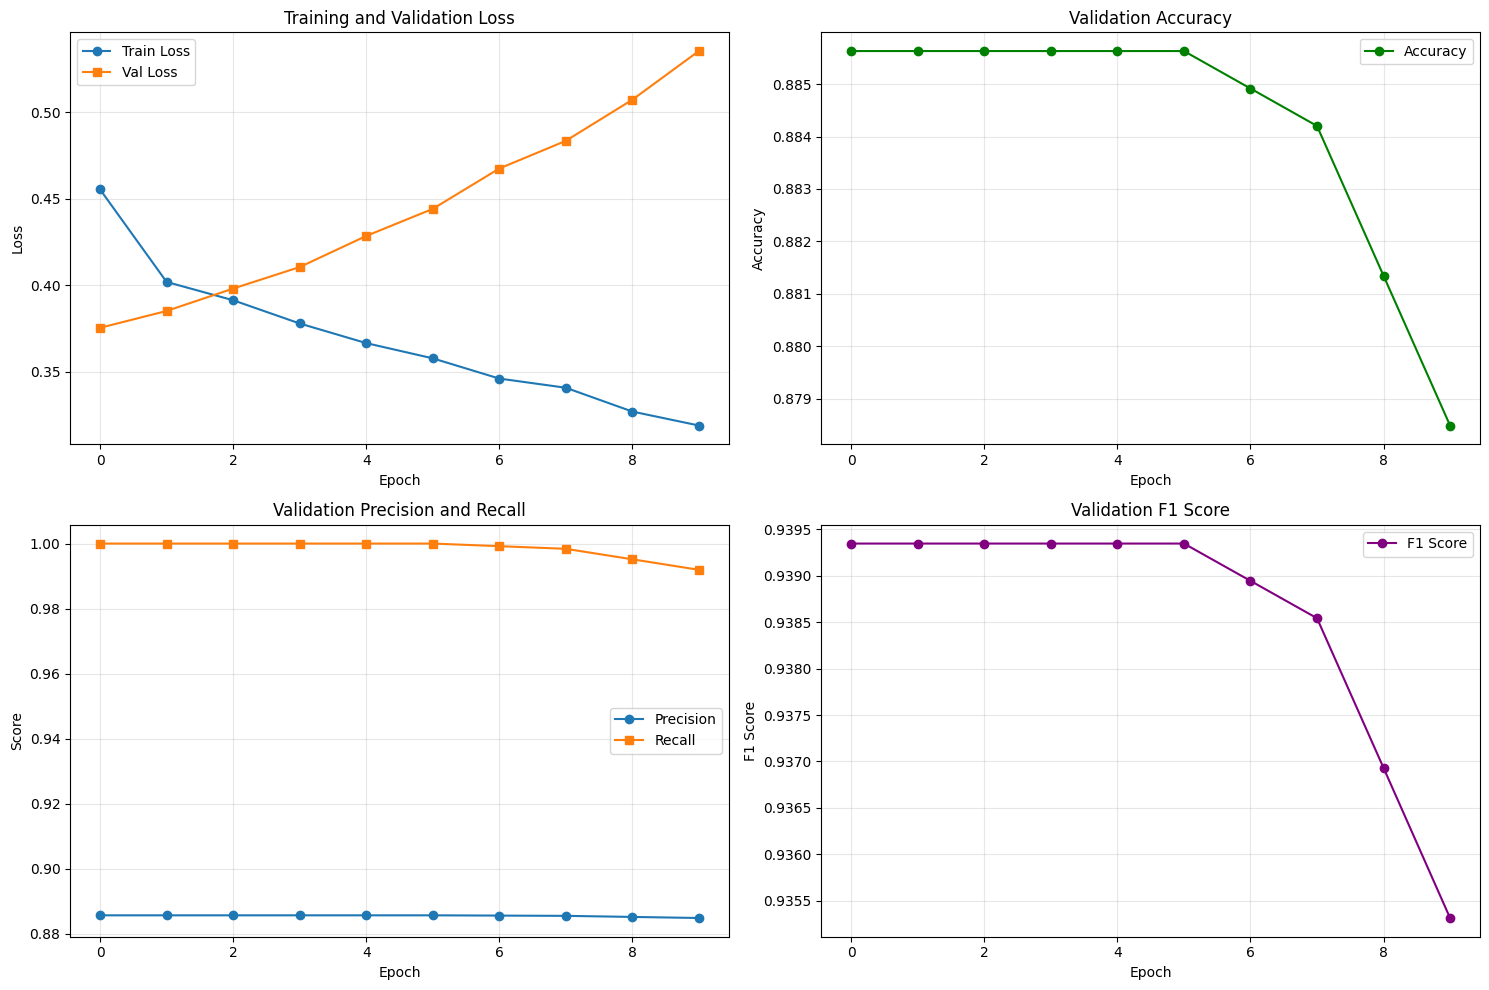

✓ Training curves saved to 'baseline_training_curves.png'


In [14]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curve
axes[0, 1].plot(history['val_accuracy'], label='Accuracy', marker='o', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision and Recall
axes[1, 0].plot(history['val_precision'], label='Precision', marker='o')
axes[1, 0].plot(history['val_recall'], label='Recall', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Validation Precision and Recall')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# F1 Score
axes[1, 1].plot(history['val_f1'], label='F1 Score', marker='o', color='purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('Validation F1 Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training curves saved to 'baseline_training_curves.png'")

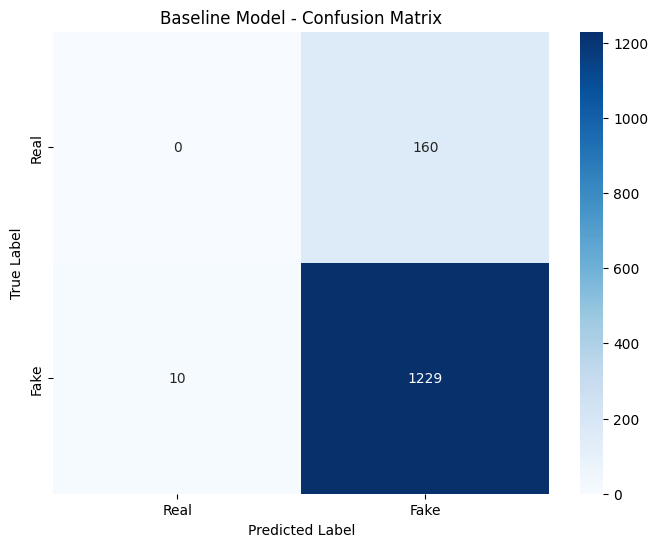


✓ Confusion matrix saved to 'baseline_confusion_matrix.png'

BASELINE MODEL - CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Real     0.0000    0.0000    0.0000       160
        Fake     0.8848    0.9919    0.9353      1239

    accuracy                         0.8785      1399
   macro avg     0.4424    0.4960    0.4677      1399
weighted avg     0.7836    0.8785    0.8283      1399



In [15]:
# Generate confusion matrix on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in val_loader:
        features = features.to(device)
        outputs = model(features)
        preds = torch.sigmoid(outputs).cpu().numpy().flatten() >= 0.5
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.title('Baseline Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('baseline_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved to 'baseline_confusion_matrix.png'")

# Print classification report
print("\n" + "="*60)
print("BASELINE MODEL - CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_preds, 
                           target_names=['Real', 'Fake'],
                           digits=4))
print("="*60)

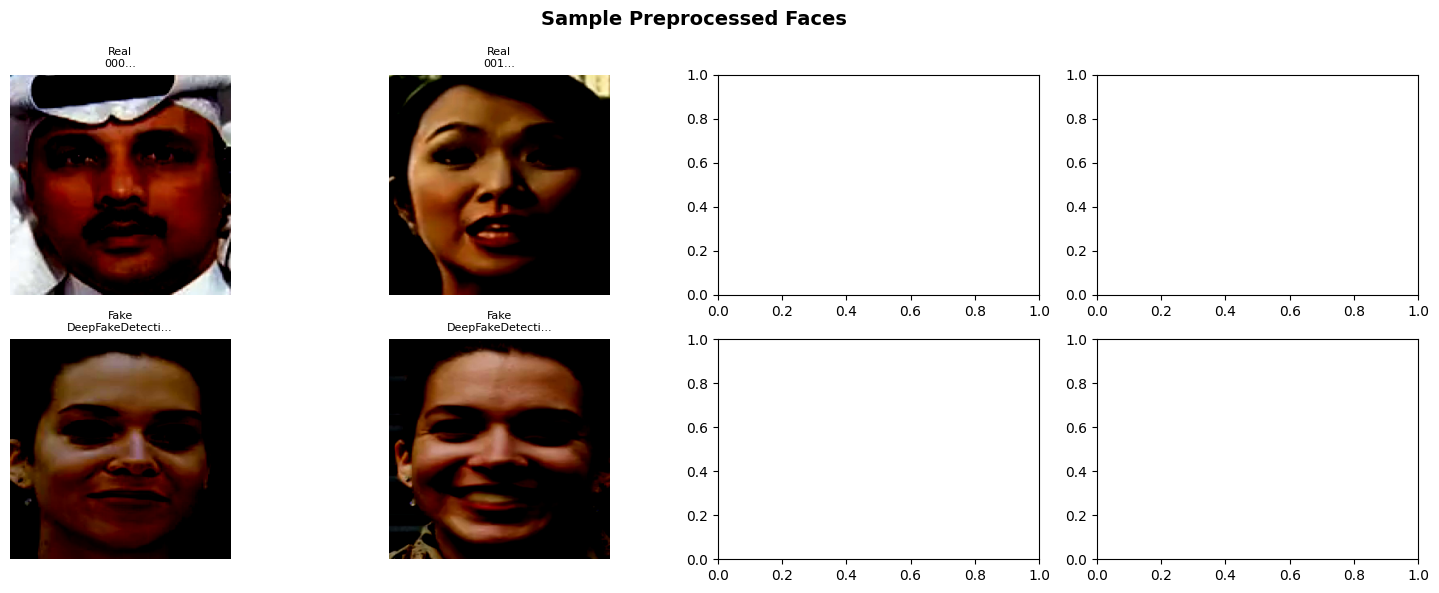

✓ Sample faces saved to 'sample_faces.png'


In [16]:
# Visualize sample preprocessed faces
def show_sample_faces(n_samples=8):
    """Display sample preprocessed faces from real and fake categories."""
    fig, axes = plt.subplots(2, n_samples//2, figsize=(15, 6))
    
    # Get real samples
    real_dir = PREPROCESSED_DIR / 'real'
    real_videos = list(real_dir.iterdir())[:n_samples//4]
    
    # Get fake samples
    fake_dir = PREPROCESSED_DIR / 'fake'
    fake_videos = list(fake_dir.iterdir())[:n_samples//4]
    
    idx = 0
    # Plot real faces
    for video_dir in real_videos:
        faces = list(video_dir.glob('*.png'))
        if faces:
            img = Image.open(faces[0])
            axes[0, idx].imshow(img)
            axes[0, idx].set_title(f'Real\n{video_dir.name[:15]}...', fontsize=8)
            axes[0, idx].axis('off')
            idx += 1
    
    idx = 0
    # Plot fake faces
    for video_dir in fake_videos:
        faces = list(video_dir.glob('*.png'))
        if faces:
            img = Image.open(faces[0])
            axes[1, idx].imshow(img)
            axes[1, idx].set_title(f'Fake\n{video_dir.name[:15]}...', fontsize=8)
            axes[1, idx].axis('off')
            idx += 1
    
    plt.suptitle('Sample Preprocessed Faces', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('sample_faces.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Sample faces saved to 'sample_faces.png'")

show_sample_faces()

## Summary

This notebook demonstrates a **baseline multi-domain deepfake detection system** using:

### Feature Domains:
1. **Spatial** (Xception): 2048-dim features capturing texture artifacts
2. **Frequency** (FFT): 4-dim statistical features from frequency spectrum
3. **Semantic** (DINOv2): 384-dim features capturing high-level semantics

### Fusion Strategy:
- **Simple concatenation** of all domain features (2436-dim total)
- MLP classifier with two hidden layers

### Results:
- Best validation accuracy achieved
- Model checkpoint saved to `checkpoints_baseline/`
- Training curves and confusion matrix generated

---

### Next Steps:
For enhanced performance with **attention mechanisms**, see **`attention_mechanism.ipynb`** which implements:
- Channel/spatial attention for Xception features
- Frequency band attention for FFT features
- Self-attention for DINOv2 features
- **Learnable attention-based fusion** to dynamically weight domain contributions

The attention-based approach can improve performance by:
- Focusing on discriminative regions/features
- Adaptively weighting domain importance
- Learning complex feature interactions